In [1]:
import numpy as np 
import string
import nltk
import re

In [2]:
with open('rent_transcript.txt') as f:
    rent = f.read().split('\n')

rent = rent[1:]

In [3]:


rent_text = rent[1: len(rent): 2]
rent_times = rent[0: len(rent) - 1: 2]

In [4]:
def seconds_counter(tm):
    splitcolons = tm.split(':')
    if len(splitcolons) == 3:
        return(int(splitcolons[0]) * 3600 + int(splitcolons[1]) * 60 + int(splitcolons[2]))
    if len(splitcolons) == 2:
        return(int(splitcolons[0]) * 60 + int(splitcolons[1]))

rent_seconds = [seconds_counter(i) for i in rent_times]

rent_breakpoints_1 = ['1:13', '2:36', '3:20', '3:58', '5:20', '9:54', '11:44',
                    '12:43', '15:27', '19:50', '20:51', '24:35', '27:51', '32:41',
                    '34:28', '38:14', '43:02', '45:00', '46:45', '50:15', '52:45',
                    '54:09', '1:00:10', '1:13:45', '1:16:25', '1:18:31'] # ends at 1,18,31
rent_breakpoints_2 = ['1:28:33', '1:31:41',
                    '1:34:50', '1:35:42', '1:40:21', '1:44:03', '1:45:45', '1:49:57',
                    '1:50:34', '1:54:20', '1:57:34', '1:59:12', '2:06:45', '2:10:25',
                    '2:11:20', '2:16:50', '2:19:59', '2:22:20']

rent_seconds_1 = [seconds_counter(i) for i in rent_breakpoints_1]


def words_compiler(starttime, stoptime):
    out = ''
    for i in range(len(rent_seconds)):
        cur_time = rent_seconds[i]
        if cur_time >=starttime and cur_time < stoptime:
            out += rent_text[i]
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
    out =  out.lower().translate(translator)
    return re.sub('\s+', ' ', out).strip()

word_list = []

for i in range(len(rent_seconds_1) - 1):
    cur_words = words_compiler(rent_seconds_1[i], rent_seconds_1[i + 1])
    word_list.append(cur_words)
print(len(word_list))

25


In [12]:
nltk.download('stopwords', 'punkt', 'wordnet')

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kerx9\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [13]:
# Modified from github.com/bagustris/text-vad

from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import csv

lmtzr = WordNetLemmatizer()
stops = set(stopwords.words("english"))
anew = "EnglishShortened.csv"
avg_V = 5.06    # average V from ANEW dict
avg_A = 4.21
avg_D = 5.18

def vad_analyzer(words):
    # Returns average V, A and D score for each song.
    all_words = []
    found_words = []
    total_words = 0
    v_list = []  # holds valence scores
    a_list = []  # holds arousal scores
    d_list = []  # holds dominance scores

    words = nltk.pos_tag(words)

    # search for each valid word's sentiment in ANEW
    for index, p in enumerate(words):
        # don't process stops or words w/ punctuation
        w = p[0]
        pos = p[1]
        if w in stops or not w.isalpha():
            continue

        # check for negation in 3 words before current word
        j = index-1
        neg = False
        while j >= 0 and j >= index-3:
            if words[j][0] == 'not' or words[j][0] == 'no' or words[j][0] == 'n\'t':
                neg = True
                break
            j -= 1

        # lemmatize word based on pos
        if pos[0] == 'N' or pos[0] == 'V':
            lemma = lmtzr.lemmatize(w, pos=pos[0].lower())
        else:
            lemma = w

        all_words.append(lemma)

        # search for lemmatized word in ANEW
        with open(anew) as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if row['Word'].casefold() == lemma.casefold():
                    if neg:
                        found_words.append("neg-"+lemma)
                    else:
                        found_words.append(lemma)
                    v = float(row['valence'])
                    a = float(row['arousal'])
                    d = float(row['dominance'])

                    if neg:
                        # reverse polarity for this word
                        v = 5 - (v - 5)
                        a = 5 - (a - 5)
                        d = 5 - (d - 5)

                    v_list.append(v)
                    a_list.append(a)
                    d_list.append(d)

    if len(found_words) == 0:  # no words found in ANEW for this sentence
        print("no found words")
        # writer.writerow({'Sentence ID': i,
        #                     'Sentence': s,
        #                     'Valence': np.nan,
        #                     'Sentiment Label': np.nan,
        #                     'Arousal': np.nan,
        #                     'Dominance': np.nan,
        #                     'Average VAD': np.nan,
        #                     '# Words Found': 0,
        #                     'Found Words': np.nan,
        #                     'All Words': all_words
        #                     })
    else:  # output sentiment info for this sentence
        # get values
        sentiment = np.mean(v_list)
        arousal = np.mean(a_list)
        dominance = np.mean(d_list)
        label = 'neutral'
        if sentiment > 6:
            label = 'positive'
        elif sentiment < 4:
            label = 'negative'
        return sentiment, arousal, dominance, label

In [20]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
V = []
A = []
D = []
for words in word_list:
    v,a,d,l = vad_analyzer(words.split(' '))
    V.append(v)
    A.append(a)
    D.append(d)
    

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kerx9\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kerx9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kerx9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kerx9\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


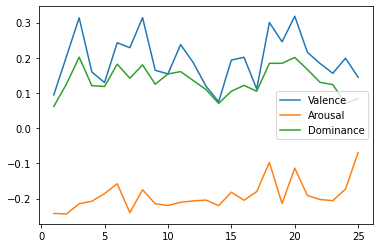

In [27]:
import matplotlib.pyplot as plt
ind = np.arange(1, 26)
plt.plot(ind, (np.array(V) - 5) / 4 , label = "Valence")
plt.plot(ind, (np.array(A) - 5) / 4 , label = "Arousal")
plt.plot(ind, (np.array(D) - 5) / 4 , label = "Dominance")
plt.legend()
plt.show()


In [21]:
np.save('rent_valences', V)
np.save('rent_arousals', A)